<a href="https://colab.research.google.com/github/anandaallif/RPS-AI-Web-Deployment_329/blob/main/RPS_AI_WEB_Model_VGG_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Ananda Allif Agita (202010370311329)**

# Library

In [ ]:
import json
import pandas as pd
import os
import numpy as np
import splitfolders
import nltk
import random
import itertools
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import seaborn as sns

from wordcloud import WordCloud
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from pytorch_tabnet.tab_model import TabNetClassifier
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from keras.applications import VGG19
from pytorch_tabnet.callbacks import Callback
from sklearn.metrics import accuracy_score
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import TFRobertaForSequenceClassification, RobertaTokenizer
from livelossplot.inputs.keras import PlotLossesCallback
from nltk.corpus import wordnet
from nltk.corpus import stopwords

# Load Dataset

In [ ]:
citra_path = "/content/drive/MyDrive/KULIAH/Semester 7/Praktikum/dataset/rps"

In [ ]:
print(f"Isi dari folder {citra_path}:")
folder_contents = os.listdir(citra_path)
for item in folder_contents:
    print(item)

Isi dari folder /content/drive/MyDrive/KULIAH/Semester 7/Praktikum/dataset/rps:
rock
scissors
paper


# Citra

**Splitting Dataset**

In [ ]:
dataset_folder_path  = '/content/drive/MyDrive/KULIAH/Semester 7/Praktikum/dataset/rps'
hasil_splitting = '/content/drive/MyDrive/KULIAH/Semester 7/Praktikum/dataset/dataset_split'

In [ ]:
classes = os.listdir(dataset_folder_path)
classes

['rock', 'scissors', 'paper']

In [ ]:
splitfolders.ratio(dataset_folder_path,
                   output=hasil_splitting,
                   ratio=(0.75, 0.15, 0.10),
                   group_prefix=None)

Copying files: 2520 files [00:52, 47.60 files/s] 


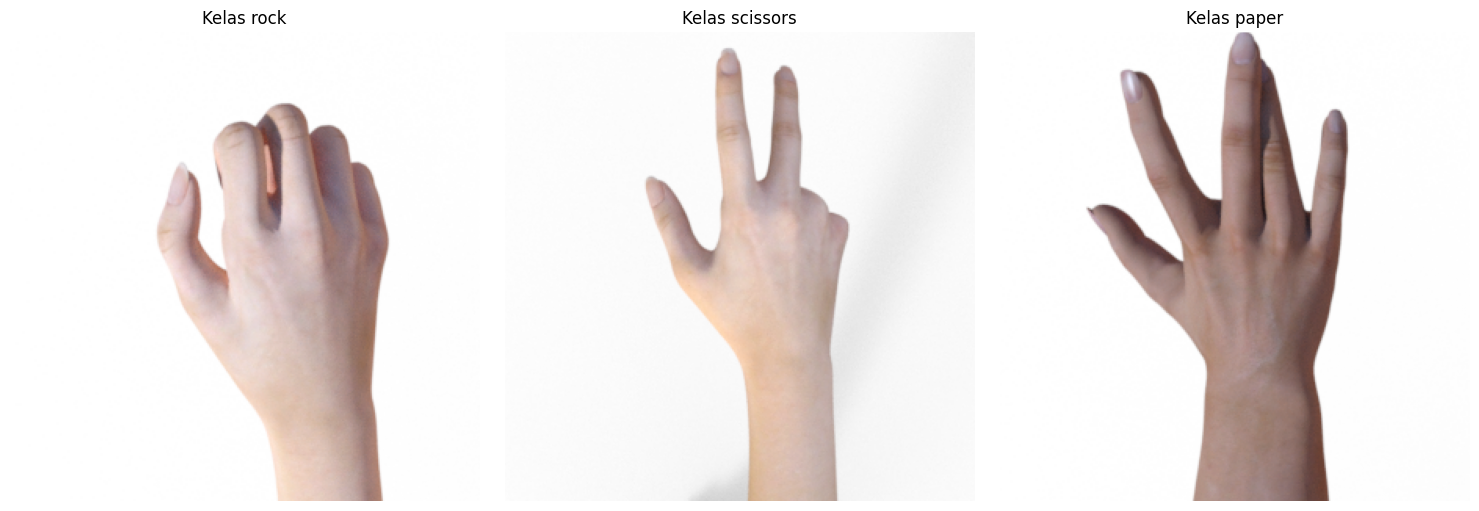

In [ ]:
kelas = ['rock', 'scissors', 'paper']

fig, axes = plt.subplots(1, len(kelas), figsize=(15, 5))

for idx, k in enumerate(kelas):
    subfolder_path = os.path.join(citra_path, k)
    files = os.listdir(subfolder_path)
    img_path = os.path.join(subfolder_path, files[0])
    img = mpimg.imread(img_path)

    axes[idx].imshow(img)
    axes[idx].set_title(f'Kelas {k}')
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

**Data Augmentation**

In [ ]:
datagen = ImageDataGenerator(
          rescale=1./255,
          rotation_range=30,
          zoom_range=0.2,
          horizontal_flip=True,
          fill_mode='nearest')

In [ ]:
datagen_test = ImageDataGenerator(
          rescale=1./255,
      )

In [ ]:
train_path = '/content/drive/MyDrive/KULIAH/Semester 7/Praktikum/dataset/dataset_split/train'

In [ ]:
val_path = '/content/drive/MyDrive/KULIAH/Semester 7/Praktikum/dataset/dataset_split/val'

In [ ]:
test_path = '/content/drive/MyDrive/KULIAH/Semester 7/Praktikum/dataset/dataset_split/test'

In [ ]:
train_gen = datagen.flow_from_directory(train_path,
                                        target_size=(150, 150),
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True)

Found 1890 images belonging to 3 classes.


In [ ]:
val_gen = datagen.flow_from_directory(val_path,
                                        target_size=(150, 150),
                                        batch_size=32,
                                        class_mode='categorical',
                                        shuffle=True)

Found 378 images belonging to 3 classes.


In [ ]:
test_gen = datagen_test.flow_from_directory(test_path,
                                        target_size=(150, 150),
                                        batch_size=64,
                                        class_mode='categorical',
                                        shuffle=False)

Found 252 images belonging to 3 classes.


In [ ]:
augmented_image = [train_gen[0][0][0] for i in range(5)]

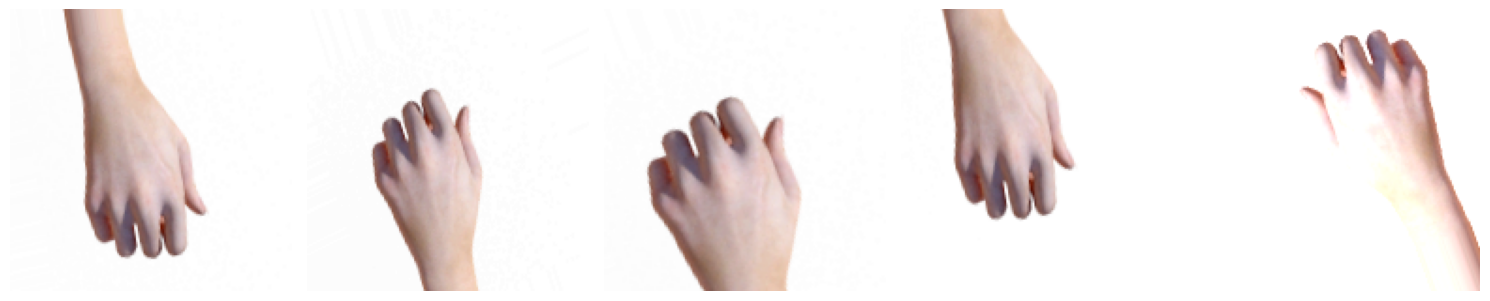

In [ ]:
fig, axes = plt.subplots(1, len(augmented_image), figsize=(15, 5))
for idx, img in enumerate(augmented_image):
    axes[idx].imshow(image.array_to_img(img))
    axes[idx].axis('off')
plt.tight_layout()
plt.show()

**MODEL**

In [ ]:
base_model = VGG19(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

80134624/80134624 [==============================] - 1s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
x = base_model.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(512, activation='relu')(x)
predictions = tf.keras.layers.Dense(3, activation='softmax')(x)

In [ ]:
model = tf.keras.models.Model(inputs=base_model.input, outputs=predictions)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
num_epochs = 3

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=len(train_gen),
    epochs=num_epochs,
    validation_data=val_gen,
    validation_steps=len(val_gen)
)

Epoch 1/3
60/60 [==============================] - 938s 16s/step - loss: 0.4909 - accuracy: 0.8259 - val_loss: 0.1908 - val_accuracy: 0.9762
Epoch 2/3
60/60 [==============================] - 816s 14s/step - loss: 0.1447 - accuracy: 0.9767 - val_loss: 0.1007 - val_accuracy: 0.9868
Epoch 3/3
60/60 [==============================] - 812s 14s/step - loss: 0.0831 - accuracy: 0.9810 - val_loss: 0.0726 - val_accuracy: 0.9841


**EVALUASI**

In [ ]:
Y_pred = model.predict(test_gen, steps=len(test_gen), verbose=1)
y_pred = np.argmax(Y_pred, axis=1)

loss_and_metrics = model.evaluate(test_gen, steps=len(test_gen), verbose=1)
print("Test Loss: ", loss_and_metrics[0])
print("Test Accuracy: ", loss_and_metrics[1])

4/4 [==============================] - 92s 23s/step - loss: 0.0347 - accuracy: 0.9960
Test Loss:  0.03465811908245087
Test Accuracy:  0.9960317611694336


In [ ]:
print('Classification Report:')
print(classification_report(test_gen.classes, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99        84
           1       1.00      1.00      1.00        84
           2       0.99      1.00      0.99        84

    accuracy                           1.00       252
   macro avg       1.00      1.00      1.00       252
weighted avg       1.00      1.00      1.00       252



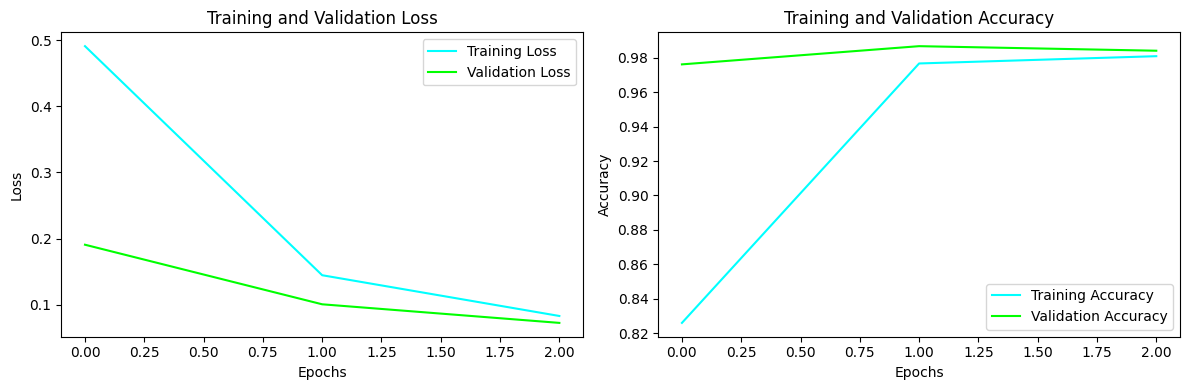

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss', color='cyan')
plt.plot(history.history['val_loss'], label='Validation Loss', color='lime')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='cyan')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='lime')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

**PREDIKSI**

In [ ]:
class_names = list(train_gen.class_indices)

1/1 [==============================] - 0s 321ms/step


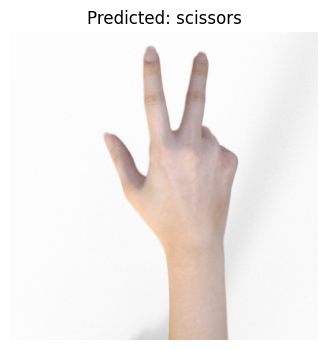

1/1 [==============================] - 0s 341ms/step


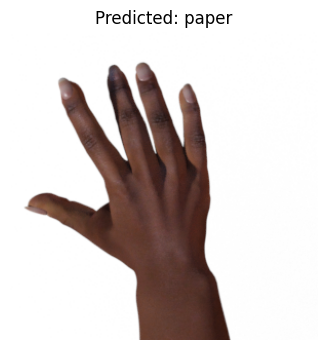

1/1 [==============================] - 1s 1s/step


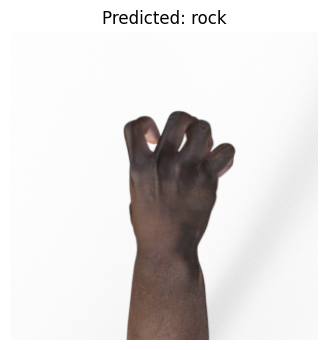

1/1 [==============================] - 1s 771ms/step


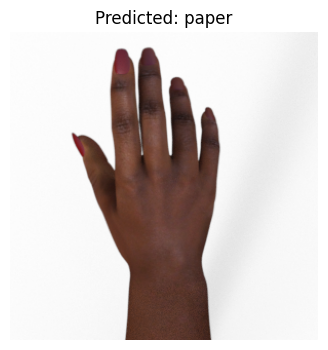

1/1 [==============================] - 1s 986ms/step


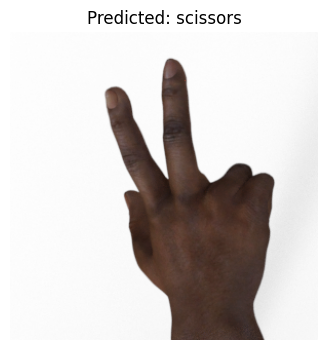

1/1 [==============================] - 1s 602ms/step


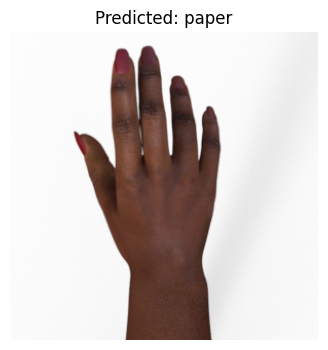

1/1 [==============================] - 1s 558ms/step


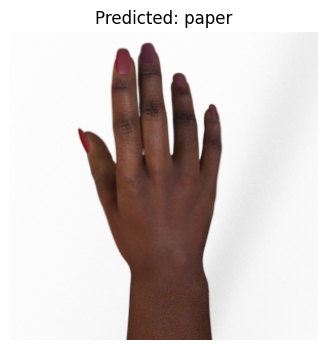

1/1 [==============================] - 1s 505ms/step


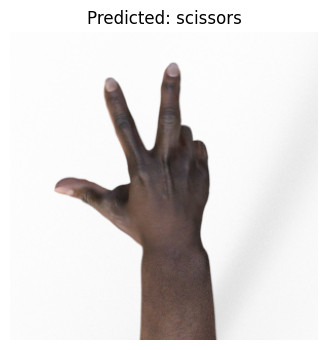

1/1 [==============================] - 1s 562ms/step


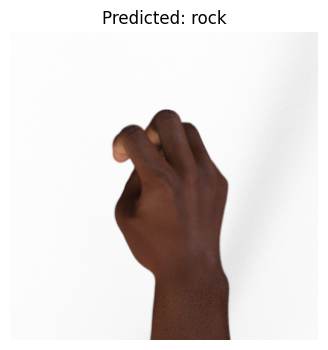

1/1 [==============================] - 1s 644ms/step


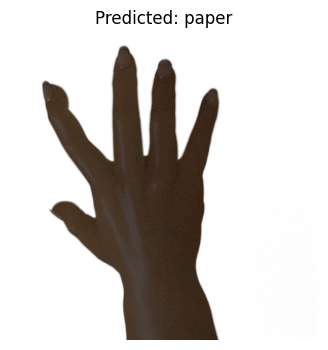

In [ ]:
random_indices = np.random.choice(len(test_gen.filenames), 10, replace=False)

for index in random_indices:
    image_path = test_gen.filepaths[index]
    img = keras.preprocessing.image.load_img(image_path, target_size=(150, 150))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)

    prediction = model.predict(img)
    predicted_class = class_names[np.argmax(prediction)]

    plt.figure(figsize=(4, 4))
    plt.imshow(plt.imread(image_path))
    plt.title(f"Predicted: {predicted_class}")
    plt.axis("off")
    plt.show()